In [3]:
import pandas as pd


## Carga de datos

In [4]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

## Indexamos el conjunto de datos

In [6]:
from sklearn.preprocessing import LabelEncoder

le_users = LabelEncoder()
le_movies = LabelEncoder()

ratings['user_id_enc'] = le_users.fit_transform(ratings['userId'])
ratings['movie_id_enc'] = le_movies.fit_transform(ratings['movieId'])


## Visualizacion de los datos

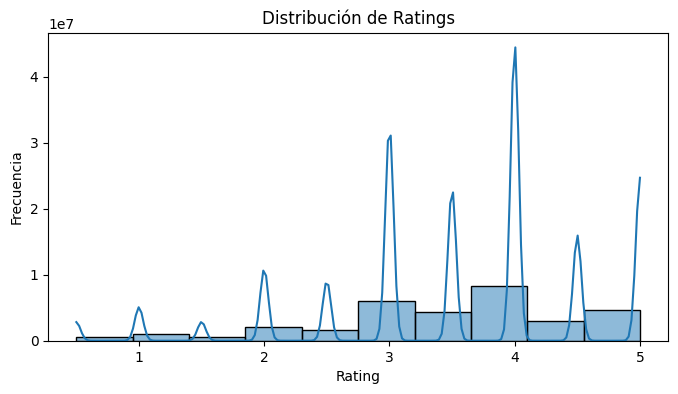

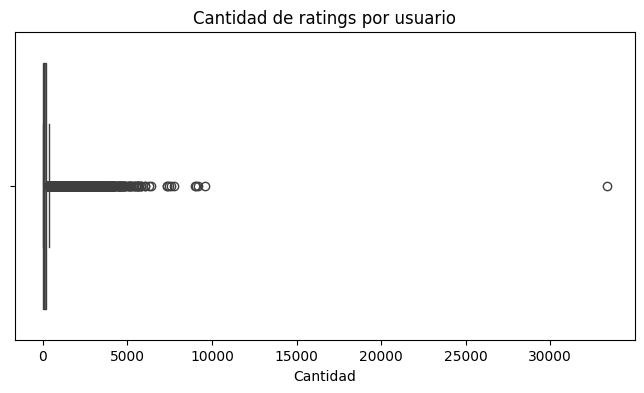

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribución de ratings
plt.figure(figsize=(8, 4))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title("Distribución de Ratings")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.show()

# Ratings por usuario
user_ratings = ratings.groupby('userId').size()
plt.figure(figsize=(8, 4))
sns.boxplot(x=user_ratings)
plt.title("Cantidad de ratings por usuario")
plt.xlabel("Cantidad")
plt.show()


## Estadisticas descriptivas

In [8]:
stats = {
    'Rating Promedio': ratings['rating'].mean(),
    'Cantidad de Usuarios': ratings['userId'].nunique(),
    'Cantidad de Películas': ratings['movieId'].nunique(),
    'Rating Mínimo': ratings['rating'].min(),
    'Rating Máximo': ratings['rating'].max(),
    'Desviación Estándar': ratings['rating'].std(),
    'Película más votada': ratings['movieId'].value_counts().idxmax(),
    'Película menos votada': ratings['movieId'].value_counts().idxmin(),
    'Usuario con más votos': ratings['userId'].value_counts().idxmax(),
    'Usuario con menos votos': ratings['userId'].value_counts().idxmin()
}

for k, v in stats.items():
    print(f"{k}: {v}")


Rating Promedio: 3.5403956487277393
Cantidad de Usuarios: 200948
Cantidad de Películas: 84432
Rating Mínimo: 0.5
Rating Máximo: 5.0
Desviación Estándar: 1.0589862139453088
Película más votada: 318
Película menos votada: 236853
Usuario con más votos: 175325
Usuario con menos votos: 200927


## Analisis de outliers

In [9]:
# Usuarios que solo dan rating alto o bajo
user_rating_extremos = ratings.groupby('userId')['rating'].agg(['min', 'max', 'mean', 'count'])

solo_5 = user_rating_extremos[user_rating_extremos['min'] == 5]
solo_0_5 = user_rating_extremos[user_rating_extremos['max'] <= 1]

print("Usuarios que solo dan 5 estrellas:", solo_5.shape[0])
print("Usuarios que solo dan 0.5 o 1 estrella:", solo_0_5.shape[0])


Usuarios que solo dan 5 estrellas: 359
Usuarios que solo dan 0.5 o 1 estrella: 23


## Segmentacion (Clustering)

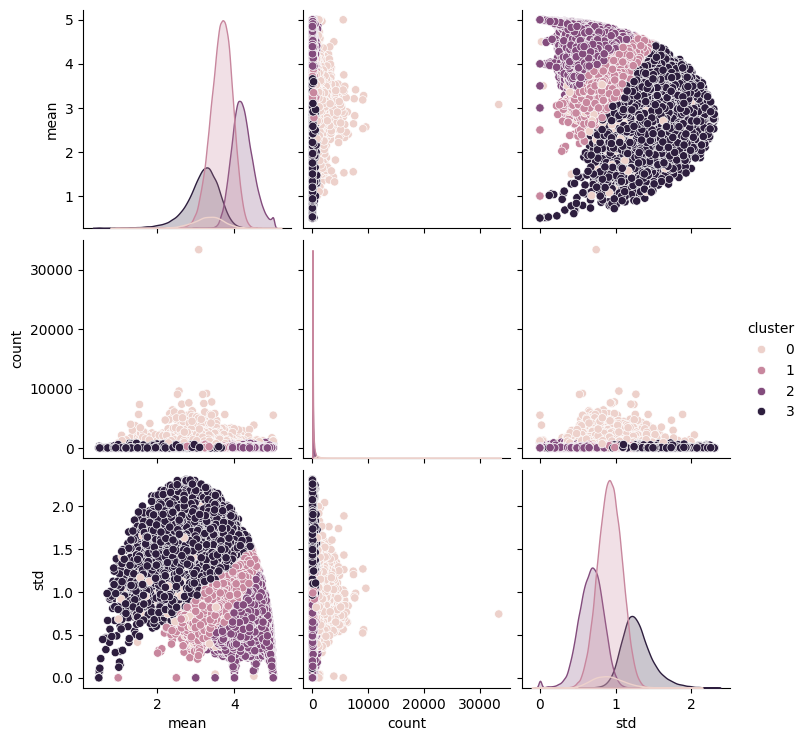

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Agrupar usuarios por comportamiento
user_stats = ratings.groupby('userId')['rating'].agg(['mean', 'count', 'std']).fillna(0)
scaler = StandardScaler()
scaled = scaler.fit_transform(user_stats)

kmeans = KMeans(n_clusters=4, random_state=42)
user_stats['cluster'] = kmeans.fit_predict(scaled)

sns.pairplot(user_stats, hue='cluster')
plt.show()


## Creacion de nuevas variables

### Test de variable

In [8]:
# Promedio de rating por usuario
ratings['user_avg_rating'] = ratings.groupby('userId')['rating'].transform('mean')

# Cantidad de ratings que ha dado cada usuario
ratings['user_rating_count'] = ratings.groupby('userId')['rating'].transform('count')

# Promedio de rating por película
ratings['movie_avg_rating'] = ratings.groupby('movieId')['rating'].transform('mean')

# Cantidad de ratings por película
ratings['movie_rating_count'] = ratings.groupby('movieId')['rating'].transform('count')

# Diferencia entre rating dado y promedio del usuario
ratings['diff_user_avg'] = ratings['rating'] - ratings['user_avg_rating']

# Diferencia entre rating dado y promedio de la película
ratings['diff_movie_avg'] = ratings['rating'] - ratings['movie_avg_rating']


## Variables basadas en peliculas

In [9]:
# Dividir los géneros en columnas binarias
genres = movies['genres'].str.get_dummies(sep='|')

# Unir con la tabla de ratings
movies = movies.join(genres)

# Promedio de rating por género
for genre in genres.columns:
    movies[f'avg_rating_{genre}'] = ratings.groupby('movieId')['rating'].transform('mean')


## Variables basadas en el tiempo

In [ ]:
# Convertir timestamp a datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Extraer características de fecha
ratings['year'] = ratings['timestamp'].dt.year
ratings['month'] = ratings['timestamp'].dt.month
ratings['day_of_week'] = ratings['timestamp'].dt.dayofweek  # 0=Lunes, 6=Domingo
ratings['hour'] = ratings['timestamp'].dt.hour

# Identificar si el rating se dio en fin de semana
ratings['is_weekend'] = (ratings['day_of_week'] >= 5).astype(int)


## Agregamos estos nuevos valores a el csv

In [ ]:
# Unir ratings con películas
final_df = ratings.merge(movies, on='movieId', how='left')

# Guardar dataset con nuevas variables
final_df.to_csv('MovieLens_32M_transformed.csv', index=False)

print(final_df.head())
